# Your first model

In [2]:
using Oceananigans
using CairoMakie

In [3]:
grid = RectilinearGrid(size=(256, 256), x=(-π, π), y=(-π, π), topology=(Periodic, Periodic, Flat))

256×256×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── Periodic x ∈ [-3.14159, 3.14159) regularly spaced with Δx=0.0245437
├── Periodic y ∈ [-3.14159, 3.14159) regularly spaced with Δy=0.0245437
└── Flat z                           

In [4]:
model = NonhydrostaticModel(; grid, tracers=:c)

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 256×256×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: Centered(order=2)
├── tracers: c
├── closure: Nothing
├── buoyancy: Nothing
└── coriolis: Nothing

In [5]:
initial_velocity(x, y) = 2rand() - 1

initial_velocity (generic function with 1 method)

In [6]:
initial_tracer(x, y) = exp(-(x^2 + y^2)/2)

initial_tracer (generic function with 1 method)

In [7]:
set!(model, u=initial_velocity, v=initial_velocity, c=initial_tracer)

In [8]:
simulation = Simulation(model, Δt=0.02, stop_time=10)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 10 seconds
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [9]:
conjure_time_step_wizard!(simulation, cfl=0.7)

In [10]:
run!(simulation)

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (3.370 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (3.178 seconds).
[ Info: Simulation is stopping after running for 34.715 seconds.
[ Info: Simulation time 10 seconds equals or exceeds stop time 10 seconds.


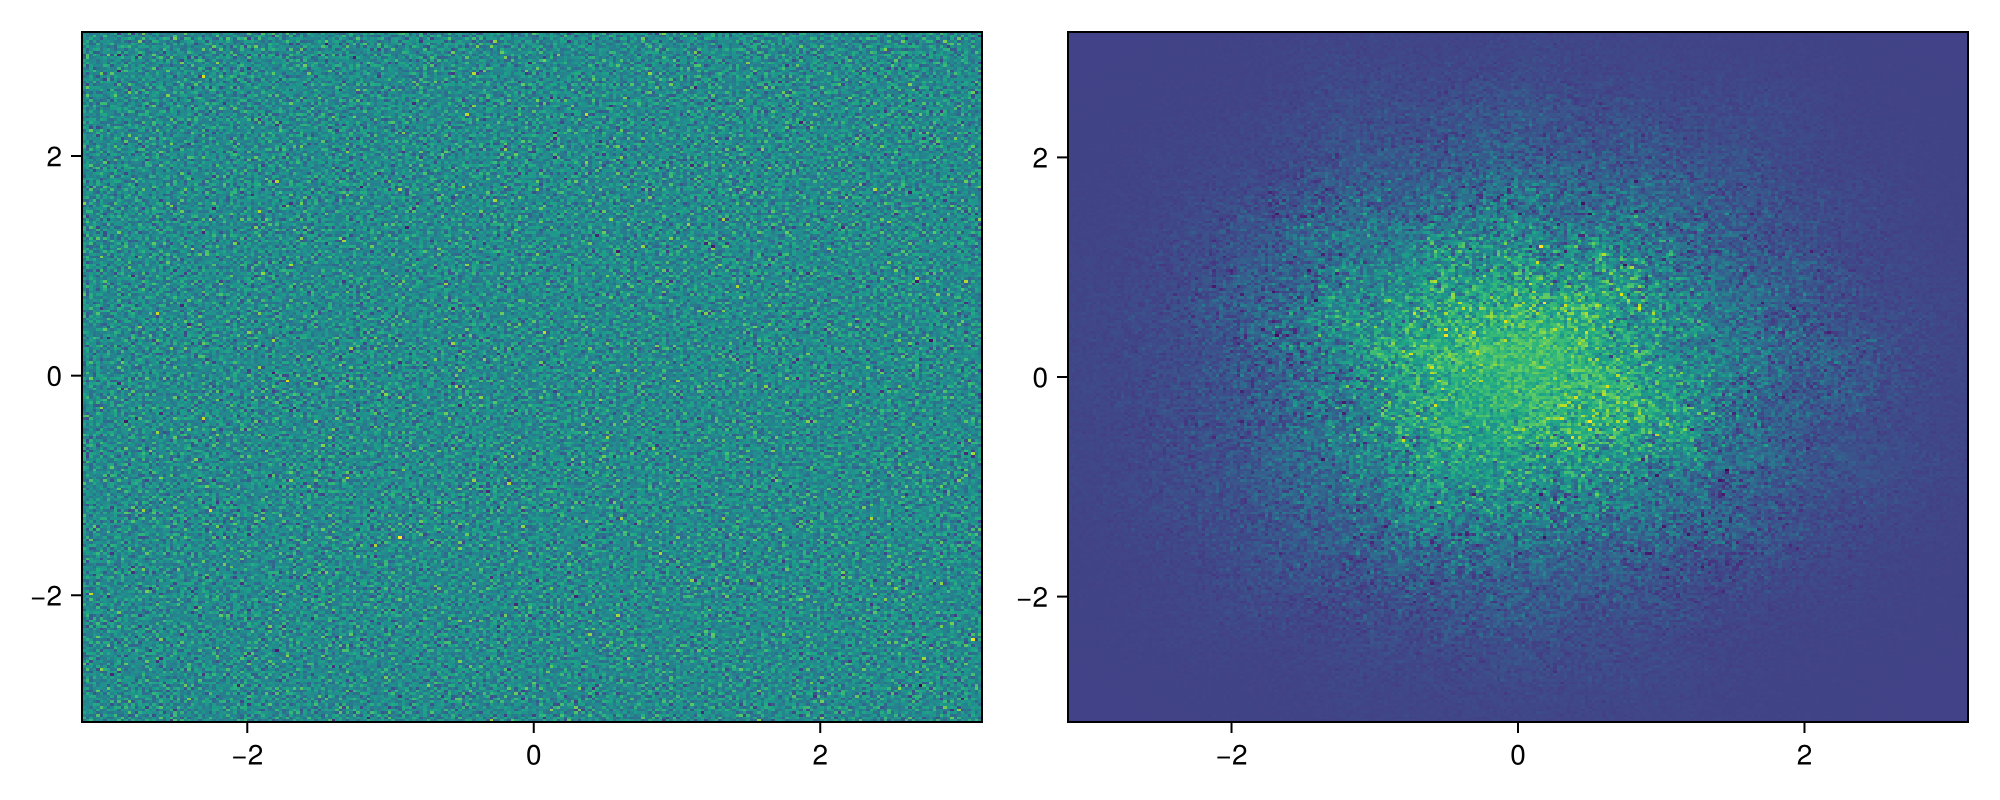

In [23]:
u, v, _ = model.velocities

fig = Figure(size=(1000, 400))
ax  = Axis(fig[1, 1])
heatmap!(ax, ∂x(v) - ∂y(u))
ax  = Axis(fig[1, 2])
heatmap!(ax, model.tracers.c)
display(fig);

In [ ]:
using Oceananigans.Operators: Az

function two_dimensional_turbulence(; advection=Centered(), closure=nothing, timestepper=:RungeKutta3)
    # Same steps as before
    model = NonhydrostaticModel(; grid, tracers=:c, advection, closure, timestepper)
    set!(model, u=initial_velocity, v=initial_velocity, c=initial_tracer)
    simulation = Simulation(model, Δt=0.02, stop_time=10)
    conjure_time_step_wizard!(simulation, cfl=0.7)
    
    # Let's compute mean energy, enstrophy, and 
    # tracer variance while time-stepping
    E  = Float64[]
    Ω  = Float64[]
    c² = Float64[]

    function save_diagnostics(sim)
        @info "Collecting diagnostic at time step $(sim.model.clock.iteration)"
        u, v, w = sim.model.velocities
        c = sim.model.tracers.c

        push!(E,  sum((u^2 + v^2) / 2 * Az))
        push!(c², sum(c^2 * Az))
        
        ζ = ∂x(v) - ∂y(v)
        push!(Ω, sum(ζ^2 * Az))
    end

    add_callback!(simulation, save_diagnostics, TimeInterval(1))

    # Now, let's run!
    run!(simulation)
    
    return model, E, Ω, c²
end

In [ ]:
model, E, Ω, c² = two_dimensional_turbulence(advection=WENO(order=9))) #closure=Smagorinsky())

In [ ]:
u, v, _ = model.velocities
fig = Figure(size = (1200, 400))
ax  = Axis(fig[1, 1])
heatmap!(ax, ∂x(v) - ∂y(u))
ax  = Axis(fig[1, 2])
heatmap!(ax, model.tracers.c)
ax = Axis(fig[1, 3])
lines!(ax, E  ./ E[1],  label = "Kinetic Energy")
lines!(ax, Ω  ./ Ω[1],  label = "Enstrophy")
lines!(ax, c² ./ c²[1], label = "Tracer variance")
axislegend(ax, position = :lb, framecolor=:transparent, backgroundcolor=:transparent)
display(fig);